In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.2 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Eval Function

In [4]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [5]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

## Data

In [6]:
# 2. Đọc file csv
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
data = pd.read_csv(company_csv)
data

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,9910,9910,9850,9850,12650,OPC
1,1,2014-01-03,9150,9910,9150,9910,2160,OPC
2,2,2014-01-06,9450,9850,9450,9850,1090,OPC
3,3,2014-01-07,9850,9850,9850,9850,200,OPC
4,4,2014-01-08,9450,9910,9450,9850,1290,OPC
...,...,...,...,...,...,...,...,...
2463,2463,2023-12-04,22500,22900,22500,22900,15300,OPC
2464,2464,2023-12-05,22900,22900,22900,22900,18500,OPC
2465,2465,2023-12-06,22900,22950,22900,22900,26000,OPC
2466,2466,2023-12-07,22900,22900,22600,22900,19100,OPC


### Choose X

## Train, test, valid

In [7]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv(company_csv)
df = df[['close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [8]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['close'])

## Build model

### Choose p, q, d

In [9]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= data[['high','open','low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37999.509, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=24731.251, Time=1.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=24699.755, Time=1.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.27 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=24760.834, Time=6.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.60 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=24707.103, Time=2.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=2.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=8.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=24699.113, Time=5.45 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24730.150, Time=3.46 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=24702.133, Time=9.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1727
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -12344.557
Date:                Sat, 16 Dec 2023   AIC                          24699.113
Time:                        15:19:56   BIC                          24726.384
Sample:                             0   HQIC                         24709.201
                               - 1727                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4003     11.922      0.369      0.712     -18.966      27.767
ar.L1          1.4072      0.040     35.272      0.000       1.329       1.485
ar.L2         -0.4075      0.040    -10.236      0.000      -0.486      -0.329
ma.L1         -0.6848      0.032    -21.575      0.000      -0.747      -0.623
sigma2      9.439e+04      0.002   4.04e+07      0.000    9.44e+04    9.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               815.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               3.92   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.06e+24. Standard errors may be unstable.
"""

### Build model

In [10]:
model = ARIMA(y_train, order=(2,0,1),exog=data[['high','open','low']][:len(y_train)]).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1727
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -11381.938
Date:                Sat, 16 Dec 2023   AIC                          22779.876
Time:                        15:19:57   BIC                          22823.509
Sample:                             0   HQIC                         22796.017
                               - 1727                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.8185     29.120      1.024      0.306     -27.256      86.893
high           0.7431      0.012     61.184      0.000       0.719       0.767
open          -0.4065      0.012    -34.206      0.000      -0.430      -0.383
low            0.6610      0.011     58.489      0.000       0.639       0.683
ar.L1          0.0598      1.147      0.052      0.958      -2.188       2.308
ar.L2          0.0234      0.135      0.174      0.862      -0.240       0.287
ma.L1          0.0594      1.149      0.052      0.959      -2.193       2.312
sigma2      3.103e+04    532.456     58.268      0.000       3e+04    3.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6816.09
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.17   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=data[['high','open','low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=data[['high','open','low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [12]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  165.23587849492077
MAPE:  0.7389650867068147
RMSE:  243.03360386149103

** Validate **
MAE:  130.74546622825048
MAPE:  0.5595412007140342
RMSE:  205.69706636260602


## Forecast

In [13]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# exogg = data[['high','open','low']][last_index-447:last_index].values.reshape(1341, 0)
# 1332 - 444 ; 1341 - 447; 1338 - 446
y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog= data[['high','open','low']][last_index-771:last_index])
#data[['high','open','low']][last_index-447:last_index]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
2468    22230.383304
2469    22610.939529
2470    22925.037944
2471    22504.187141
2472    22824.245447
2473    23023.768056
2474    22974.918596
2475    22974.918596
2476    22786.061563
2477    22842.105214
2478    22974.918596
2479    22684.237874
2480    22875.157291
2481    22875.157291
2482    22875.157291
2483    22883.358519
2484    22825.276639
2485    22699.633292
2486    22610.740671
2487    22651.388904
2488    22809.053136
2489    22609.530527
2490    22675.634682
2491    22692.037137
2492    22736.180911
2493    22659.813144
2494    22773.333602
2495    22875.157291
2496    22912.309983
2497    22676.844826
Name: predicted_mean, dtype: float64


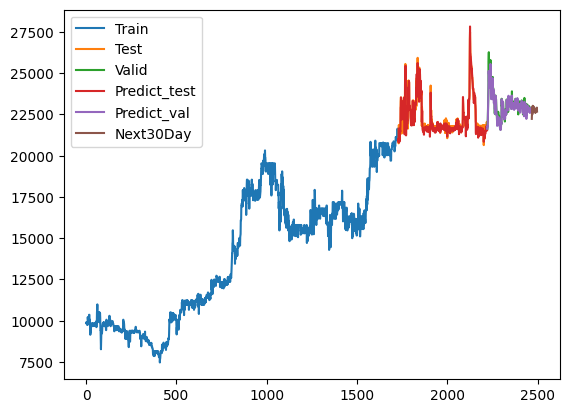

In [14]:
plt.plot(train_data.index, train_data['close'])
plt.plot(test_data.index, test_data['close'])
plt.plot(val_data.index, val_data['close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()